Version from Fri 19th July 2024
Import all you need:

In [1]:
#!pip install torchvision --quiet

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch libraries
import torch
import nlp_nets as nlp
from torch import nn
import torch.optim as optim
from os.path import join as opj
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.auto import tqdm

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Set up seeds

In [2]:
SEED = 5
nlp.set_seed(SEED)
DEVICE = nlp.set_device()
g_seed = torch.Generator()
#g_seed.manual_seed(SEED)

Random seed 5 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


Load and process data

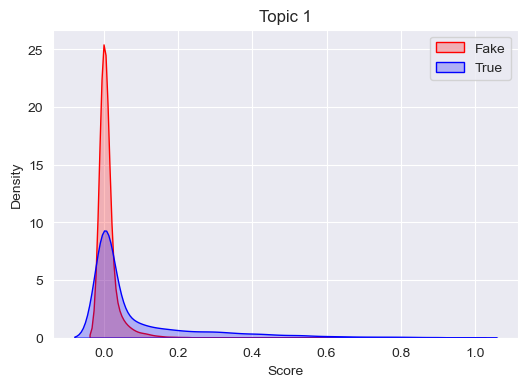

In [3]:
# data folder
folder_dir = opj('/', 'Users', 'doctordu', 'Documents', 'Github', 'Neuromatch_NLP', 'dataset')

# load labels 
arr_labels_train = torch.from_numpy(np.load(opj(folder_dir, 'train_labels.npy')))
arr_labels_test = torch.from_numpy(np.load(opj(folder_dir, 'test_labels.npy')))
arr_labels_val = torch.from_numpy(np.load(opj(folder_dir, 'validation_labels.npy')))

# load emotional scores and article text
df_train = pd.read_csv(opj(folder_dir, 'train_df.csv'))
df_test = pd.read_csv(opj(folder_dir, 'test_df.csv'))
df_val = pd.read_csv(opj(folder_dir, 'validation_df.csv'))
arr_emo_train = torch.from_numpy(nlp.emo_str2arr(df_train['emotions']))
arr_emo_test = torch.from_numpy(nlp.emo_str2arr(df_test['emotions']))
arr_emo_val = torch.from_numpy(nlp.emo_str2arr(df_val['emotions']))
nFeatures_emo = arr_emo_train.shape[1]

# load word embeddings
arr_embed_train = torch.from_numpy(np.load(opj(folder_dir, 'train_embeddings_200.npy')))
arr_embed_test = torch.from_numpy(np.load(opj(folder_dir, 'test_embeddings_200.npy')))
arr_embed_val = torch.from_numpy(np.load(opj(folder_dir, 'validation_embeddings_200.npy')))
nFeatures_embed = arr_embed_train.shape[1]

# load topics 
arr_topics_train = torch.from_numpy(np.load(opj(folder_dir, 'topic_distributions_train.npy')))
arr_topics_test = torch.from_numpy(np.load(opj(folder_dir, 'topic_distributions_test.npy')))
arr_topics_val = torch.from_numpy(np.load(opj(folder_dir, 'topic_distributions_validation.npy')))

# sanity check: plot topic distributions
nTopic = 1 # pick topic
plt.figure(figsize=(6, 4))
sns.kdeplot(arr_topics_train[arr_labels_train == 1,nTopic], color='red', fill=True, label='Fake')
sns.kdeplot(arr_topics_train[arr_labels_train == 0,nTopic], color='blue', fill=True, label='True')

plt.xlabel('Score')
plt.ylabel('Density')

plt.title(f"Topic {nTopic}")
plt.legend()

# remove some topic scores if needed
keep_topics = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
arr_topics_train = arr_topics_train[:, keep_topics]
arr_topics_test = arr_topics_test[:, keep_topics]
arr_topics_val = arr_topics_val[:, keep_topics]
nFeatures_topics = arr_topics_train.shape[1]

# merge embeddings and topics 
arr_EmoEmbed_train = torch.cat([arr_emo_train, arr_embed_train], dim = 1)
arr_EmoEmbed_test = torch.cat([arr_emo_test, arr_embed_test], dim = 1)
arr_EmoEmbed_val = torch.cat([arr_emo_val, arr_embed_val], dim = 1)
nFeatures_EmoEmbed = arr_EmoEmbed_train.shape[1]


Conditions for data exclusion 

tensor(32475)


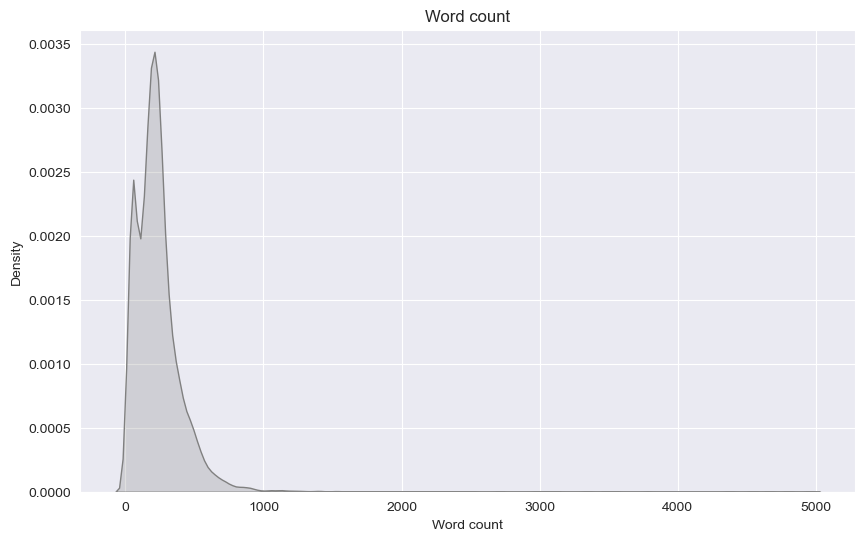

In [5]:
# get boolean vectors 

# word count
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))
df_val['word_count'] = df_val['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
word_count_total = pd.concat([df_train['word_count'], df_test['word_count'], df_val['word_count']]).to_numpy()
sns.kdeplot(word_count_total, color='gray', fill=True)
plt.xlabel('Word count')
plt.ylabel('Density')
plt.title("Word count")

thr_WordCount = 50
idx_word_train = df_train['word_count'].to_numpy() > thr_WordCount
idx_word_test = df_test['word_count'].to_numpy() > thr_WordCount
idx_word_val = df_val['word_count'].to_numpy() > thr_WordCount

# Cosine similarity 
idx_cos_train = np.load(opj(folder_dir, 'train_cosine_similarity.npy')).astype(bool)
idx_cos_test = np.load(opj(folder_dir, 'test_cosine_similarity.npy')).astype(bool)
idx_cos_val = np.load(opj(folder_dir, 'val_cosine_similarity.npy')).astype(bool)

# get boolean vectors based on all conditions 
idx_train = torch.tensor(idx_word_train & idx_cos_train)
idx_test = torch.tensor(idx_word_test & idx_cos_test)
idx_val = torch.tensor(idx_word_val & idx_cos_val)


print(torch.sum(idx_train)+torch.sum(idx_test)+torch.sum(idx_val))




Pack to TensorDatasets

In [6]:
dataset_train_emo = TensorDataset(arr_emo_train[idx_train,:], arr_labels_train[idx_train])
dataset_test_emo = TensorDataset(arr_emo_test[idx_test,:], arr_labels_test[idx_test])
dataset_val_emo = TensorDataset(arr_emo_val[idx_val,:], arr_labels_val[idx_val])

dataset_train_embed = TensorDataset(arr_embed_train[idx_train,:], arr_labels_train[idx_train])
dataset_test_embed = TensorDataset(arr_embed_test[idx_test,:], arr_labels_test[idx_test])
dataset_val_embed = TensorDataset(arr_embed_val[idx_val,:], arr_labels_val[idx_val])

dataset_train_topics = TensorDataset(arr_topics_train[idx_train,:], arr_labels_train[idx_train])
dataset_test_topics = TensorDataset(arr_topics_test[idx_test,:], arr_labels_test[idx_test])
dataset_val_topics = TensorDataset(arr_topics_val[idx_val,:], arr_labels_val[idx_val])

dataset_train_EmoEmbed = TensorDataset(arr_EmoEmbed_train[idx_train,:], arr_labels_train[idx_train])
dataset_test_EmoEmbed = TensorDataset(arr_EmoEmbed_test[idx_test,:], arr_labels_test[idx_test])
dataset_val_EmoEmbed = TensorDataset(arr_EmoEmbed_val[idx_val,:], arr_labels_val[idx_val])

Pack data into loaders

In [7]:
batch_size = 6000

emo_train_loader, emo_val_loader, emo_test_loader = nlp.load_data(dataset_train_emo, dataset_val_emo, dataset_test_emo, batch_size, g_seed)

embed_train_loader, embed_val_loader, embed_test_loader = nlp.load_data(dataset_train_embed, dataset_val_embed, dataset_test_embed, batch_size, g_seed)

topic_train_loader, topic_val_loader, topic_test_loader = nlp.load_data(dataset_train_topics, dataset_val_topics,dataset_test_topics, batch_size, g_seed)

EmoEmbed_train_loader, EmoEmbed_val_loader, EmoEmbed_test_loader = nlp.load_data(dataset_train_EmoEmbed, dataset_val_EmoEmbed,dataset_test_EmoEmbed, batch_size, g_seed)


Hyperparameters: 

In [8]:
units_multiplier = 5


Run MLP on the emotion scores

Random seed 5 has been set.


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on the 18000 training samples: 72.26
Accuracy on the 6510 testing samples: 72.10


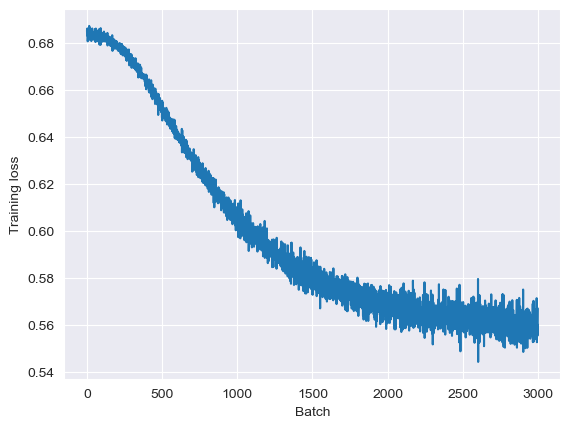

In [12]:
nlp.set_seed(SEED)

net = nlp.Net('ReLU()', nFeatures_emo, [nFeatures_emo*units_multiplier], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 1000

_, _ = nlp.train_test_classification(net, criterion, optimizer, emo_train_loader,
                                 emo_test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Run MLP on word embeddings

Random seed 5 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on the 18000 training samples: 100.00
Accuracy on the 6510 testing samples: 96.97


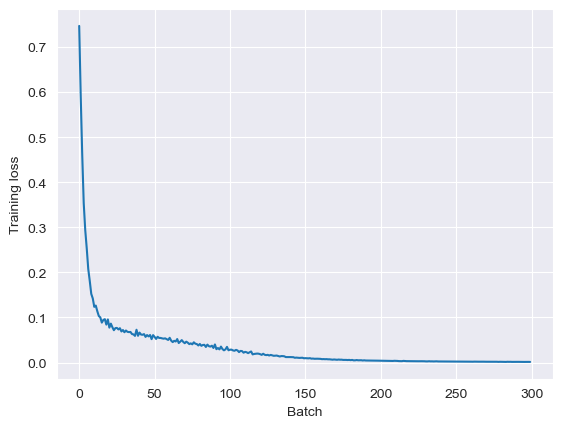

In [13]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_embed, [nFeatures_embed*units_multiplier], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100

_, _ = nlp.train_test_classification(net, criterion, optimizer, embed_train_loader,
                                 embed_test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

Run MLP on merged features (emotional scores + embedding)

Random seed 278341638 has been set.


  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy on the 24000 training samples: 100.00
Accuracy on the 6000 testing samples: 97.02


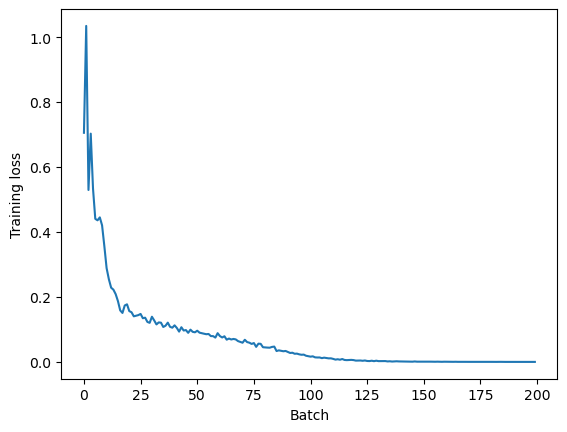

In [58]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_embed+nFeatures_emo, [(nFeatures_embed+nFeatures_emo)*units_multiplier], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 50

_, _ = nlp.train_test_classification(net, criterion, optimizer, EmoEmbed_train_loader,
                                 EmoEmbed_test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)


Run MLP on topic scores

Random seed 5 has been set.


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on the 18000 training samples: 92.27
Accuracy on the 6510 testing samples: 91.67


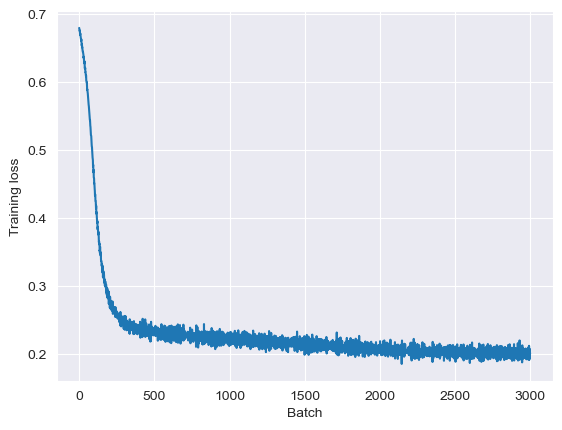

In [14]:
nlp.set_seed(SEED)
net = nlp.Net('ReLU()', nFeatures_topics, [nFeatures_topics*units_multiplier], 2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 1000

_, _ = nlp.train_test_classification(net, criterion, optimizer, topic_train_loader,
                                 topic_test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)